<a href="https://colab.research.google.com/github/prathameshbhalekar/Neural-Network-From-Scratch/blob/master/Feed_Forward_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import numpy as np
from sklearn.metrics import log_loss


class FeedForwardNeuralNetwork:
    def __init__(self,layers,activation_functions,loss_function='ce'):
        self.layers=layers
        self.layer_count=len(layers)
        self.activation_functions=activation_functions
        self.loss_function=loss_function
        assert self.layer_count==len(self.activation_functions)+1
        self.weights=[]
        for i in range(1,self.layer_count):
          self.weights.append(np.random.randn(self.layers[i],self.layers[i-1]))
        self.biases = [np.zeros((x, 1)) for x in self.layers[1:]]
        
    def forwardPass(self,X):
      self.inputs=[]
      self.outputs=[]
      W=self.weights
      b=self.biases


      for layer in range(0,self.layer_count-1):
        if layer==0:
          self.inputs.append(np.matmul(W[layer],X.T)+self.biases[layer])
        else:
          self.inputs.append(np .matmul(W[layer],self.outputs[layer-1])+self.biases[layer])

        if self.activation_functions[layer]=='relu':
          self.outputs.append(self.relu(self.inputs[layer]))
        elif self.activation_functions[layer]=='stable_softmax':
          self.outputs.append(self.stable_softmax(self.inputs[layer]))
        elif self.activation_functions[layer]=='sigmoid':
          self.outputs.append(self.sigmoid(self.inputs[layer]))
      return self.outputs[-1]

    def backwardPropogate(self,X,Y,prediction):
      grad_layers=[0 for _ in range(self.layer_count)]
      grad_weights=[0 for _ in range(len(self.weights))]
      grad_biases=[0 for _ in range(len(self.biases))]
      samples=X.shape[0]
      for layer in reversed(range(self.layer_count-1)):
        if layer==self.layer_count-2:
          if self.loss_function=='ce':
            grad_layers[layer]=prediction-Y.T
        else:
          if self.activation_functions[layer]=='relu':
            grad_layers[layer]=(np.matmul(self.weights[layer+1].T,grad_layers[layer+1]))*self.relu(grad_layers[layer],derivative=True)

        
        if layer!=0:
          grad_weights[layer]=(1/samples) * np.matmul(grad_layers[layer],self.outputs[layer-1].T)
        else:
          grad_weights[layer]=(1/samples) * np.matmul(grad_layers[layer],X)
        grad_biases[layer]=(1/samples) * np.sum(grad_layers[layer],axis=1,keepdims=True)
      return (grad_layers,grad_weights,grad_biases)
    
    def train(self,X,Y,eta=0.01,batch_size=30,max_epochs=100,optimizer='gd',momentum=0.8):
      training_loss=[]
      t=0
      v_b=0
      v_w=0
      m_b=0
      m_w=0
      prev_grad_weights=np.multiply(self.weights,0)
      prev_grad_biases=np.multiply(self.biases,0)
      for epoch in range (max_epochs):
        step=0
        batch_loss=0
        for num in range(0,X.shape[0],batch_size):
          batch_X=X[num:num+batch_size]
          batch_Y=Y[num:num+batch_size]
          predictions=self.forwardPass(batch_X)
          (grad_layers, grad_weights,grad_biases) = self.backwardPropogate(batch_X,batch_Y, predictions)
          if optimizer=='gd':
            update_w = np.multiply(eta,grad_weights)
            update_b = np.multiply(eta,grad_biases)
            
          if optimizer=='momentum':
            update_w = np.multiply(eta,grad_weights)+np.multiply(momentum,prev_grad_weights)
            update_b = np.multiply(eta,grad_biases)+np.multiply(momentum,prev_grad_biases)
            prev_grad_weights=update_w
            prev_grad_biases=update_b
          if optimizer=='adagrad':
            e=1e-8
            v_w=v_w+np.power(grad_weights,2)
            v_b=v_b+np.power(grad_biases,2)
            mul_w=1/np.power(v_w+e,1/2)
            mul_b=1/np.power(v_b+e,1/2)
            update_w=np.multiply(grad_weights,mul_w)*eta
            update_b=np.multiply(grad_biases,mul_b)*eta
            
          if optimizer=='rms_prop':
            e=1e-8
            beta=0.95
            v_w=v_w*beta+(1-beta)*np.power(grad_weights,2)
            v_b=v_b*beta+(1-beta)*np.power(grad_biases,2)
            mul_w=1/np.power(v_w+e,1/2)
            mul_b=1/np.power(v_b+e,1/2)
            update_w=np.multiply(grad_weights,mul_w)*eta
            update_b=np.multiply(grad_biases,mul_b)*eta
          if optimizer=='adam':
            e=1e-8
            beta1=0.95
            beta2=0.99
            
            m_w=np.multiply(m_w,beta1)+np.multiply((1-beta1),grad_weights)
            m_b=np.multiply(m_b,beta1)+np.multiply((1-beta1),grad_biases)

            v_w=v_w*beta2+(1-beta2)*np.power(grad_weights,2)
            v_b=v_b*beta2+(1-beta2)*np.power(grad_biases,2)

            m_w=m_w/(1-np.power(beta1,t+1))
            m_b=m_b/(1-np.power(beta1,t+1))

            v_w=v_w/(1-np.power(beta2,t+1))
            v_b=v_b/(1-np.power(beta2,t+1))

            mul_w=1/np.power(v_w+e,1/2)
            mul_b=1/np.power(v_b+e,1/2)

            update_w=np.multiply(mul_w,m_w)*eta
            update_b=np.multiply(mul_b,m_b)*eta




          self.weights=self.weights-update_w
          self.biases=self.biases-update_b
          t=t+1
          if self.loss_function == 'ce':           
              batch_loss += log_loss(batch_Y.T,predictions)
        training_loss.append(batch_loss)
        predictions_train=self.forwardPass(X)
        (acc_train, correct_train,total_train) = self.evaluate(predictions_train.T, Y)
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print('Epoch {0} Training Loss {1}'.format(epoch, training_loss[epoch]))
        print('Epoch {0} : Training Accuracy : {1}%'.format(epoch, round(acc_train , 2)))
            

    def relu(self, x, derivative = False):
        if derivative == False:
            return np.maximum(0, x, x)
        else:
            return np.greater(x,0).astype(int)
    
    def stable_softmax(self, x, derivative = False):
        if derivative == False:
            out = np.zeros(x.shape)
            for i in range(0, x.shape[1]):
                exps = np.exp(x[:, i] - np.max(x[:, i]))
                out[:, i] = exps / np.sum( exps)
                
            return out
        else:
            pass
        
        return
    def softmax(self, x, derivative = False):
        if derivative == False:
            
            out = np.zeros(x.shape)
            
            for i in range(0, x.shape[1]):
                exps = np.exp(x[:, i])
                out[:, i] = exps / np.sum( exps)
                
            return out
        else:
            pass
        
        return
    def evaluate(self, predictions, y):
        accuracyMatrix = np.argmax(predictions, axis = 1).reshape(y.shape[0], 1) == np.argmax(y, axis = 1).reshape(y.shape[0], 1)
        accuracyList = accuracyMatrix.tolist()
        correct = accuracyList.count([True])
        total = len(accuracyList)
        acc = correct/total
        acc = round(acc*100, 2)
        return (acc,correct,total)

In [ ]:
from tensorflow.keras import datasets
(train_featureset,train_labels),(test_featureset,test_labels)=datasets.fashion_mnist.load_data()
X=[]
train_featureset=train_featureset/255.0
for i in range(train_featureset.shape[0]):
    X.append(train_featureset[i].reshape(28*28))
X_test=[]
test_featureset=test_featureset/255.0
for i in range(test_featureset.shape[0]):
    X_test.append(test_featureset[i].reshape(28*28))
Y=np.zeros((train_labels.shape[0],10))
for i in range(train_labels.shape[0]):
    Y[i][train_labels[i]]=1
Y_test=np.zeros((test_labels.shape[0],10))
for i in range(test_labels.shape[0]):
    Y_test[i][test_labels[i]]=1

In [33]:
model=FeedForwardNeuralNetwork([28*28,64,128,10],['relu','relu','stable_softmax'])
model.train(np.array(X),np.array(Y),max_epochs=20,optimizer='adam',momentum=0.2)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 0 Training Loss 148388.40091072003
Epoch 0 : Training Accuracy : 7.9%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1 Training Loss 148375.38743050324
Epoch 1 : Training Accuracy : 7.9%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2 Training Loss 148349.79126574486
Epoch 2 : Training Accuracy : 7.9%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3 Training Loss 148335.9398446314
Epoch 3 : Training Accuracy : 7.9%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 4 Training Loss 148197.47715493402
Epoch 4 : Training Accuracy : 7.95%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [ ]:
import matplotlib.pyplot as plt
def predict(pos):
  v=model.forwardPass(np.array([X_test[pos]]))
  plt.imshow(X_test[pos].reshape((28,28)))
  v=v.T[0]
  class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
  l=max(v)
  c=0
  for i in v:
      if i==l:
          print(class_names[c])
      c=c+1

Shirt


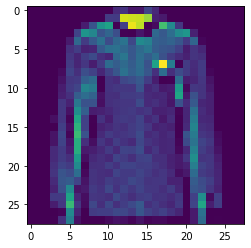

In [48]:
predict(724)